## Plots delays, throughputs, packet loss and path for a selected link

In [1]:
%matplotlib inline
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
from datetime import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import gridspec
from datetime import datetime
import numpy as np
import pandas as pd

es = Elasticsearch(['atlas-kibana.mwt2.org:9200'],timeout=60)
indices = "network_weather-2017.8.*"

my_query = {}

##  Select your link

In [2]:
# sS='UC'
# srcSiteOWDServer = "192.170.227.160"
# srcSiteThroughputServer = "192.170.227.162"

sS='CERN-PROD'
srcSiteOWDServer = "128.142.223.247"
srcSiteThroughputServer = "128.142.223.246"

# dS='IU'
# destSiteOWDServer = "149.165.225.223"
# destSiteThroughputServer = "149.165.225.224"

# dS='UIUC'
# destSiteOWDServer = "72.36.96.4"
# destSiteThroughputServer = "72.36.96.9"

# dS='ICCN'
# destSiteOWDServer = "72.36.96.4"
# destSiteThroughputServer = "72.36.126.132"

dS='pic'
destSiteOWDServer = "193.109.172.188"
destSiteThroughputServer = "193.109.172.187"

## Get the data from Elasticsearch, and store the record based on its type

In [3]:
my_query = {
    'query': { 
       'bool':{
            'must':[
                    {'range': {'timestamp': {'gte': '20170803T000000Z', 'lt': '20170810T000000Z'}}},
                        {'bool':
                            {'should':[
                                {'term': {'src': srcSiteOWDServer}},
                                #{'term': {'src': srcSiteThroughputServer}},
                                {'term': {'src': destSiteOWDServer}},
                                #{'term': {'src': destSiteThroughputServer}}
                            ]}
                        },
                        {'bool':
                            {'should':[
                                {'term': {'dest': destSiteOWDServer}},
                                #{'term': {'dest': destSiteThroughputServer}},
                                {'term': {'dest': srcSiteOWDServer}},
                                #{'term': {'dest': srcSiteThroughputServer}}
                            ]}
                        }
                    ]
                }
        
        }
    }


scroll = list(scan(client=es, index=indices, query=my_query))


In [4]:
site = {srcSiteOWDServer: sS, srcSiteThroughputServer: sS, destSiteOWDServer:dS, destSiteThroughputServer:dS}
data = {sS:pd.DataFrame(),dS:pd.DataFrame()}
epoch = datetime.utcfromtimestamp(0)
count = 0
for res in scroll:
    if count<1: print(res)
    count += 1
#     dt=datetime.strptime(res['_source']['timestamp'], '%Y-%m-%dT%H:%M:%S') # for data before Oct. 15 2016
    dt=datetime.utcfromtimestamp(res['_source']['timestamp']/1000.0)
    ts = (dt - epoch).total_seconds() * 1000.0
    s=site[res['_source']['src']]
    data[s].set_value(ts, 'timestamp', dt)
    column_type = res['_type']
#    if column_type == 'latency':
#        data[s].set_value( ts, 'delay_median', res['_source']['delay_median'])
#        data[s].set_value( ts, 'delay_mean', res['_source']['delay_mean'])
#        data[s].set_value( ts, 'delay_sd', res['_source']['delay_sd'])
    if column_type == 'packet_loss_rate':
        data[s].set_value( ts, 'packet_loss', res['_source']['packet_loss'])
#    elif column_type == 'throughput':
#        data[s].set_value( ts, 'throughput', res['_source']['throughput']/1024./1024./1024.)
#    elif column_type == 'traceroute':
#        data[s].set_value( ts, 'hash', res['_source']['hash'])
print(count)

{'_index': 'network_weather-2017.8.20', '_type': 'latency', '_source': {'srcProduction': True, 'destVO': 'ATLAS', 'dest': '128.142.223.247', 'srcSite': 'pic', 'delay_mean': 15.604833333333334, 'timestamp': 1503187206000, 'delay_median': 15.43, 'dest_host': 'perfsonar-lt.cern.ch', 'MA': '193.109.172.188', 'src_host': 'psl01.pic.es', 'destProduction': True, 'srcVO': 'ATLAS', 'delay_sd': 1.738300023650182, 'destSite': 'CERN-PROD', 'ipv6': False, 'src': '193.109.172.188'}, '_score': None, 'sort': [6], '_id': 'AV388P04NILXDji8UuZH'}
317761


In [5]:
data[sS].sort_index(inplace=True) 
data[sS].describe()

data[dS].sort_index(inplace=True) 
data[dS].describe()

,packet_loss
count,82411.000000
mean,0.000251
std,0.005373
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,0.831667


### Extract values

In [10]:
F = data[sS]
B = data[dS]
#Fthr = F[F.throughput.notnull()]    # Get the lines (i.e. times) whose throughput is not null
#Bthr = B[B.throughput.notnull()]  
Fpl = F[F.packet_loss.notnull()]
Bpl = B[B.packet_loss.notnull()]
# Fd = F[F.delay_mean.notnull()]
# Bd = B[B.delay_mean.notnull()]
#Fd = F[F.delay_mean<150]
#Bd = B[B.delay_mean<150]
#Jd = Fd.join(Bd,how='inner', rsuffix="_back")
#Jd['dmean']= (Jd.delay_mean + Jd.delay_mean_back)/2

#Fh = F[F.hash.notnull()]
#Bh = B[B.hash.notnull()]
Fids=[];Bids=[]
Fu=[];Bu=[]

#for fi in Fh.hash.tolist():
#    if fi not in Fu: Fu.append(fi)
#    Fids.append(Fu.index(fi))
#for fi in Bh.hash.tolist():
#    if fi not in Bu: Bu.append(fi)
#    Bids.append(Bu.index(fi))

#### interpolate all the values and leave only onese where all 4 measurements are there

In [15]:
NF=F.interpolate(method='index',limit=3,limit_direction='both')
#NFall = NF[NF.throughput.notnull()]
#NFall = NFall[NFall.delay_mean.notnull()]
NFall = NF[NF.packet_loss.notnull()]
#NFall = NFall[NFall.hash.notnull()]

NB=B.interpolate(method='index',limit=3,limit_direction='both')
#NBal = NB[NB.throughput.notnull()]
#NBall = NB[NB.delay_mean.notnull()]
print(NFall.shape,NB.shape)

(76540, 2) (85027, 2)


In [16]:
#NFall

In [17]:
#print( 'throughput  forward: ', Fthr.shape[0], ' backward: ', Bthr.shape[0])
print( 'packet loss forward: ', Fpl.shape[0],  ' backward: ', Bpl.shape[0])
#print( 'delay       forward: ', Fd.shape[0],   ' backward: ', Bd.shape[0])
#print( 'hash        forward: ', Fh.shape[0],   ' backward: ', Bh.shape[0])

packet loss forward:  73588  backward:  82411


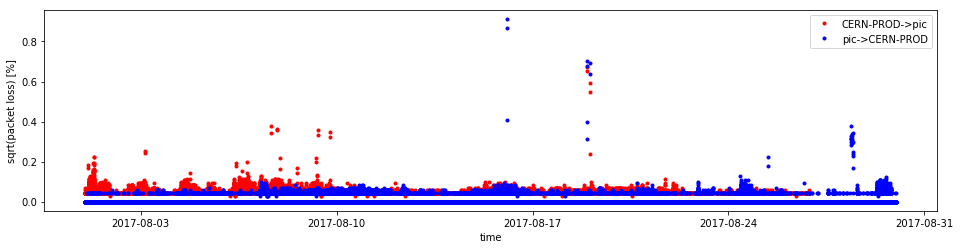

In [18]:
plt.figure(figsize=[16, 17])
gs = gridspec.GridSpec(4, 1)

#ax0 = plt.subplot(gs[0])
#ax0.plot(Fthr.timestamp.tolist(), Fthr.throughput.tolist(), ls='-', marker='>', c='r', label=sS+'->'+dS)
#ax0.plot(Bthr.timestamp.tolist(), Bthr.throughput.tolist(), ls='-', marker='<', c='b', label=dS+'->'+sS)
#ax0.set_xlabel('time')
#ax0.set_ylabel('throughput [Gbps]')#,rotation='horizontal')
#ax0.xlim(xmin=0)
#ax0.legend()

ax2 = plt.subplot(gs[1])
ax2.plot(Fpl.timestamp.tolist(), np.sqrt(Fpl.packet_loss).tolist(), ls='', marker='.', c='r', label=sS+'->'+dS)
ax2.plot(Bpl.timestamp.tolist(), np.sqrt(Bpl.packet_loss).tolist(), ls='', marker='.', c='b', label=dS+'->'+sS)
ax2.set_xlabel('time')
ax2.set_ylabel('sqrt(packet loss) [%]')
ax2.legend()

#ax4 = plt.subplot(gs[2])
#ax4.plot(Fd.timestamp.tolist(), Fd.delay_mean.tolist(), ls='', marker='.', c='r', label=sS+'->'+dS)
#ax4.plot(Bd.timestamp.tolist(), Bd.delay_mean.tolist(), ls='', marker='.', c='b', label=dS+'->'+sS)
#ax4.plot(Jd.timestamp.tolist(), Jd.dmean.tolist(), ls='-', marker='.', c='g', label='mean delay')
#ax4.set_xlabel('time')
#ax4.set_ylabel('one way delay [ms]')
#ax4.legend()

#ax6 = plt.subplot(gs[3])
#ax6.plot(Fh.timestamp.tolist(), Fids, ls='', marker='.', c='r', label=sS+'->'+dS)
#ax6.plot(Bh.timestamp.tolist(), Bids, ls='', marker='.', c='b', label=dS+'->'+sS)
#ax6.set_xlabel('time')
#ax6.set_ylabel('path index')
#ax6.legend()

#plt.savefig('Plots/4PlotForLink_' + sS +'_'+ dS + '.png',dpi=200)
plt.show()

ValueError: x and y must be the same size

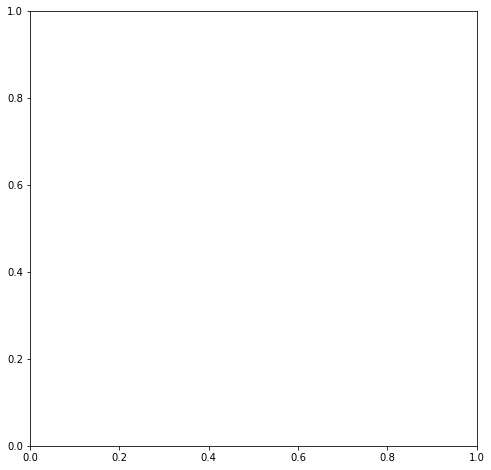

In [22]:
plt.figure(figsize=[8, 8])

#print (NFall.delay_mean.tolist(),NFall.throughput.tolist(),NFall.packet_loss.tolist())

cm = plt.cm.get_cmap('RdYlBu')

#sc=plt.scatter(NFall.delay_mean.tolist(), NFall.packet_loss.tolist(), c=NFall.throughput.tolist(), vmin=0, vmax=10, cmap=cm, alpha=0.5, label=sS+'->'+dS)
sc=plt.scatter(NFall.packet_loss.tolist(), y = 3100, vmin=0, vmax=10, cmap=cm, alpha=0.5, label=sS+'->'+dS)
#plt.scatter(NBall.delay_mean.tolist(), NBall.packet_loss.tolist(), c=NBall.throughput.tolist(), vmin=0, vmax=10, cmap=cm, alpha=0.5, label=dS+'->'+sS)
plt.xlabel('one way delay [ms]')
plt.ylabel('packet loss')#,rotation='horizontal')
plt.ylim(ymin=-0.0001)
plt.xscale("log")
plt.colorbar(sc)
plt.legend()

#ax2 = plt.subplot(gs[1])
#heatmap = ax2.pcolor(NFall.delay_mean.tolist(), NFall.throughput.tolist(), NFall.delay_mean.tolist(), cmap='PuBu_r')
# ax2.plot(Fpl.timestamp.tolist(), np.sqrt(Fpl.packet_loss).tolist(), ls='', marker='.', c='r', label=sS+'->'+dS)
# ax2.plot(Bpl.timestamp.tolist(), np.sqrt(Bpl.packet_loss).tolist(), ls='', marker='.', c='b', label=dS+'->'+sS)
# ax2.set_xlabel('time')
# ax2.set_ylabel('sqrt(packet loss) [%]')
# ax2.legend()

# ax4 = plt.subplot(gs[2])
# ax4.plot(Fd.timestamp.tolist(), Fd.delay_mean.tolist(), ls='', marker='.', c='r', label=sS+'->'+dS)
# ax4.plot(Bd.timestamp.tolist(), Bd.delay_mean.tolist(), ls='', marker='.', c='b', label=dS+'->'+sS)
# ax4.plot(Jd.timestamp.tolist(), Jd.dmean.tolist(), ls='-', marker='.', c='g', label='mean delay')
# ax4.set_xlabel('time')
# ax4.set_ylabel('one way delay [ms]')
# ax4.legend()


#plt.savefig('Plots/CorrelationPlotsForLink_' + sS +'_'+ dS + '.png',dpi=200)
plt.show()